## Data Preparation

In [1]:
# libraries

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# city regions

regions = [
    'Aldoar',
    'Bonfim',
    'Campanha',
    'Centro',
    'Lordelo',
    'Paranhos',
    'Ramalde'
]

In [3]:
# read json files

region_data = {region: pd.read_json(f'outputs/{region.lower()}.json') for region in regions}

In [4]:
def get_global_limits(regions, region_data):
    global_limits = {
        'home_time': [float('inf'), float('-inf')],
        'charger': [float('inf'), float('-inf')],
        'queue': [float('inf'), float('-inf')],
        'stress': [float('inf'), float('-inf')],
        'wait': [float('inf'), float('-inf')],
        'charging_time': [float('inf'), float('-inf')]
    }
    for region in regions:
        data = region_data[region]
        for key in global_limits.keys():
            global_limits[key][0] = min(global_limits[key][0], min(data[key]))
            global_limits[key][1] = max(global_limits[key][1], max(data[key]))
    return {key: global_limits[key] for key in global_limits.keys()}

In [5]:
# get global min and max values

global_limits = get_global_limits(regions, region_data)

global_limits

{'home_time': [0.0, 230.0],
 'charger': [0, 34.5],
 'queue': [0, 0],
 'stress': [0, 0.35000000000000003],
 'wait': [0, 0],
 'charging_time': [0, 45.33]}

In [6]:
# steps to days and hours

steps_per_day = 1440  # minutes in a day
number_of_days = 1
steps = steps_per_day * number_of_days
time_labels = []
for day in range(1, number_of_days + 1):
    for hour in range(24):
        for minute in range(60):
            time_labels.append(f"{day}d {hour:02d}h")
minute_interval = 240   # 4 hours
reduced_labels = [time_labels[i] for i in range(0, len(time_labels), minute_interval)]


## Results Visualization

In [7]:
def plot_metric(metric, title, label, regions, region_data, porto_data, limits, color):
    num_regions = len(regions)
    cols = 2
    rows = (num_regions + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
    fig.suptitle(title)
    axes = axes.flatten()
    min_value, max_value = limits
    y_min = min_value - 0.02 * (max_value - min_value)
    y_max = max_value + 0.02 * (max_value - min_value)
    for i, region in enumerate(regions):
        ax = axes[i]
        ax.plot(region_data[region][metric], color=color)
        ax.set_title(region)
        ax.set_xlabel("Time")
        ax.set_ylabel(label)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(ticks=np.arange(0, steps, minute_interval))
        ax.set_xticklabels(reduced_labels, rotation=45)
    ax_total = axes[-1]
    ax_total.plot(porto_data, color='b')
    ax_total.set_title("Porto")
    ax_total.set_xlabel("Time")
    ax_total.set_ylabel(label)
    ax_total.set_ylim(y_min, y_max)
    ax_total.set_xticks(ticks=np.arange(0, steps, minute_interval))
    ax_total.set_xticklabels(reduced_labels, rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

### Charger Utilization Rate

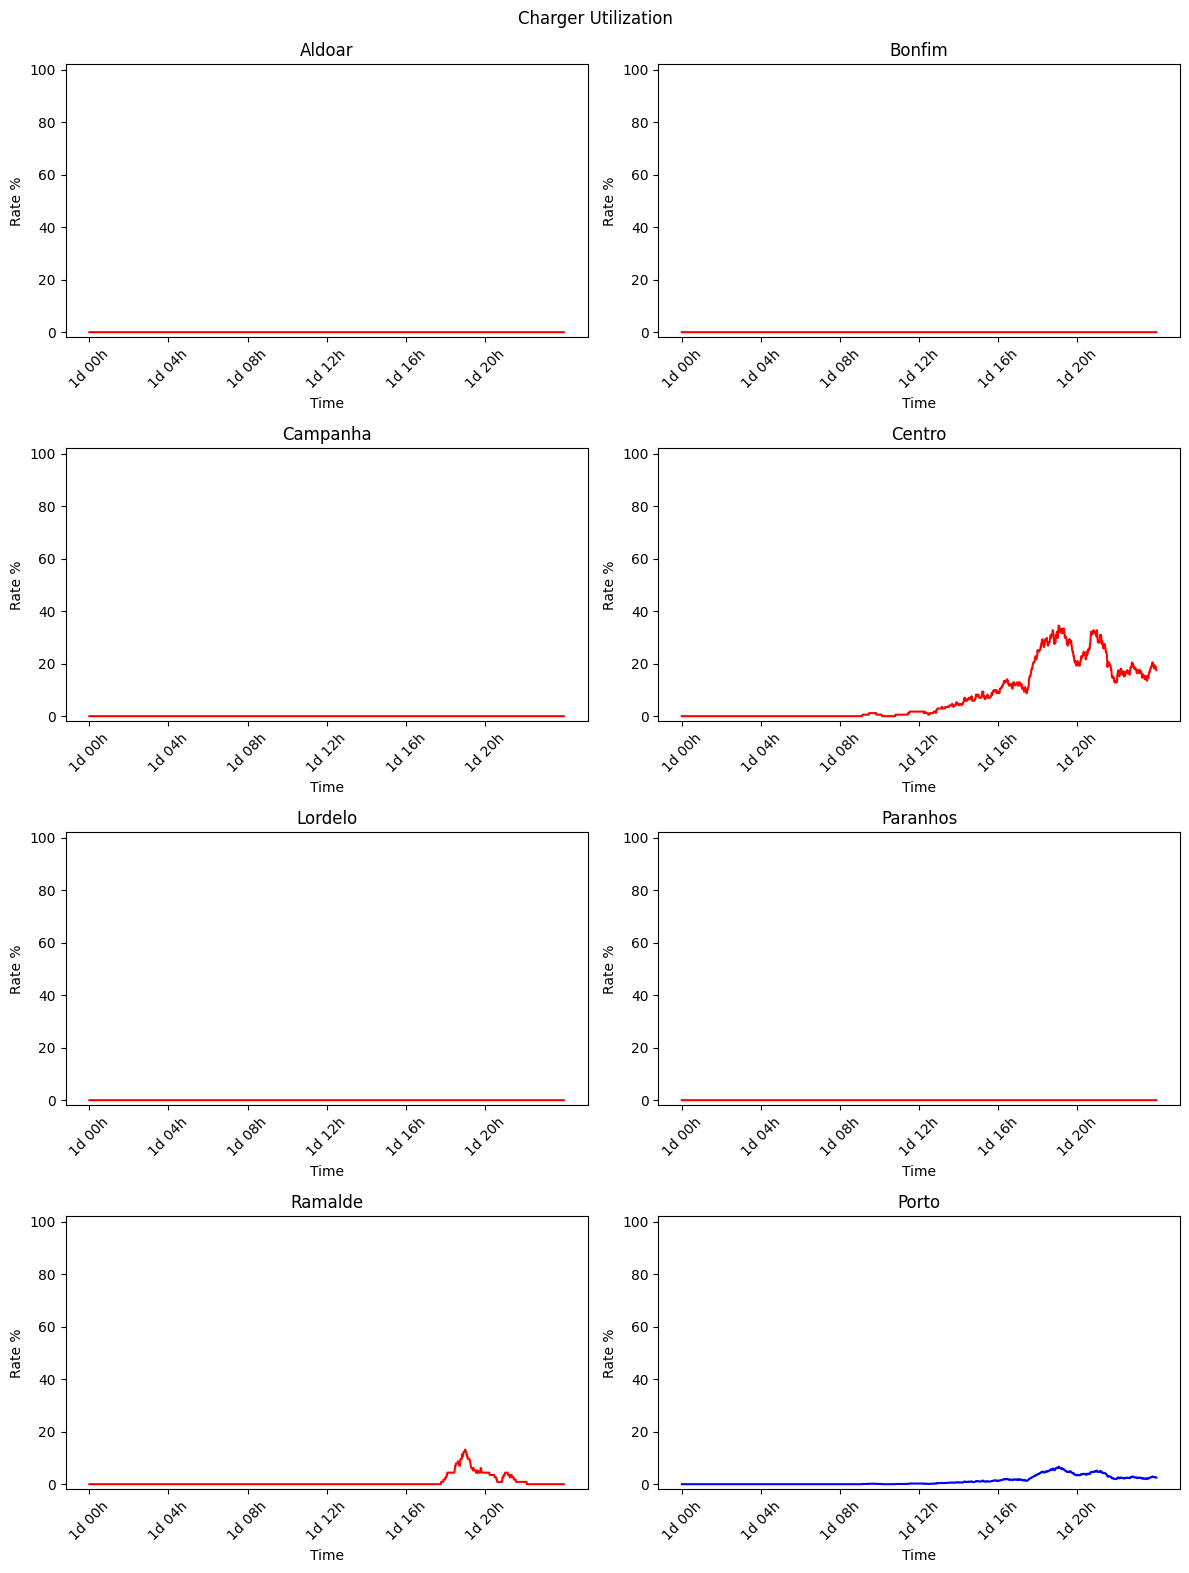

In [11]:
porto_data = np.zeros(steps)
for region in regions:
    porto_data += region_data[region]['charger']
porto_data = porto_data / len(regions)
limits = [0, 100]

plot_metric('charger', 'Charger Utilization', 'Rate %', regions, region_data, porto_data, limits, 'r')

### Average Queue Size

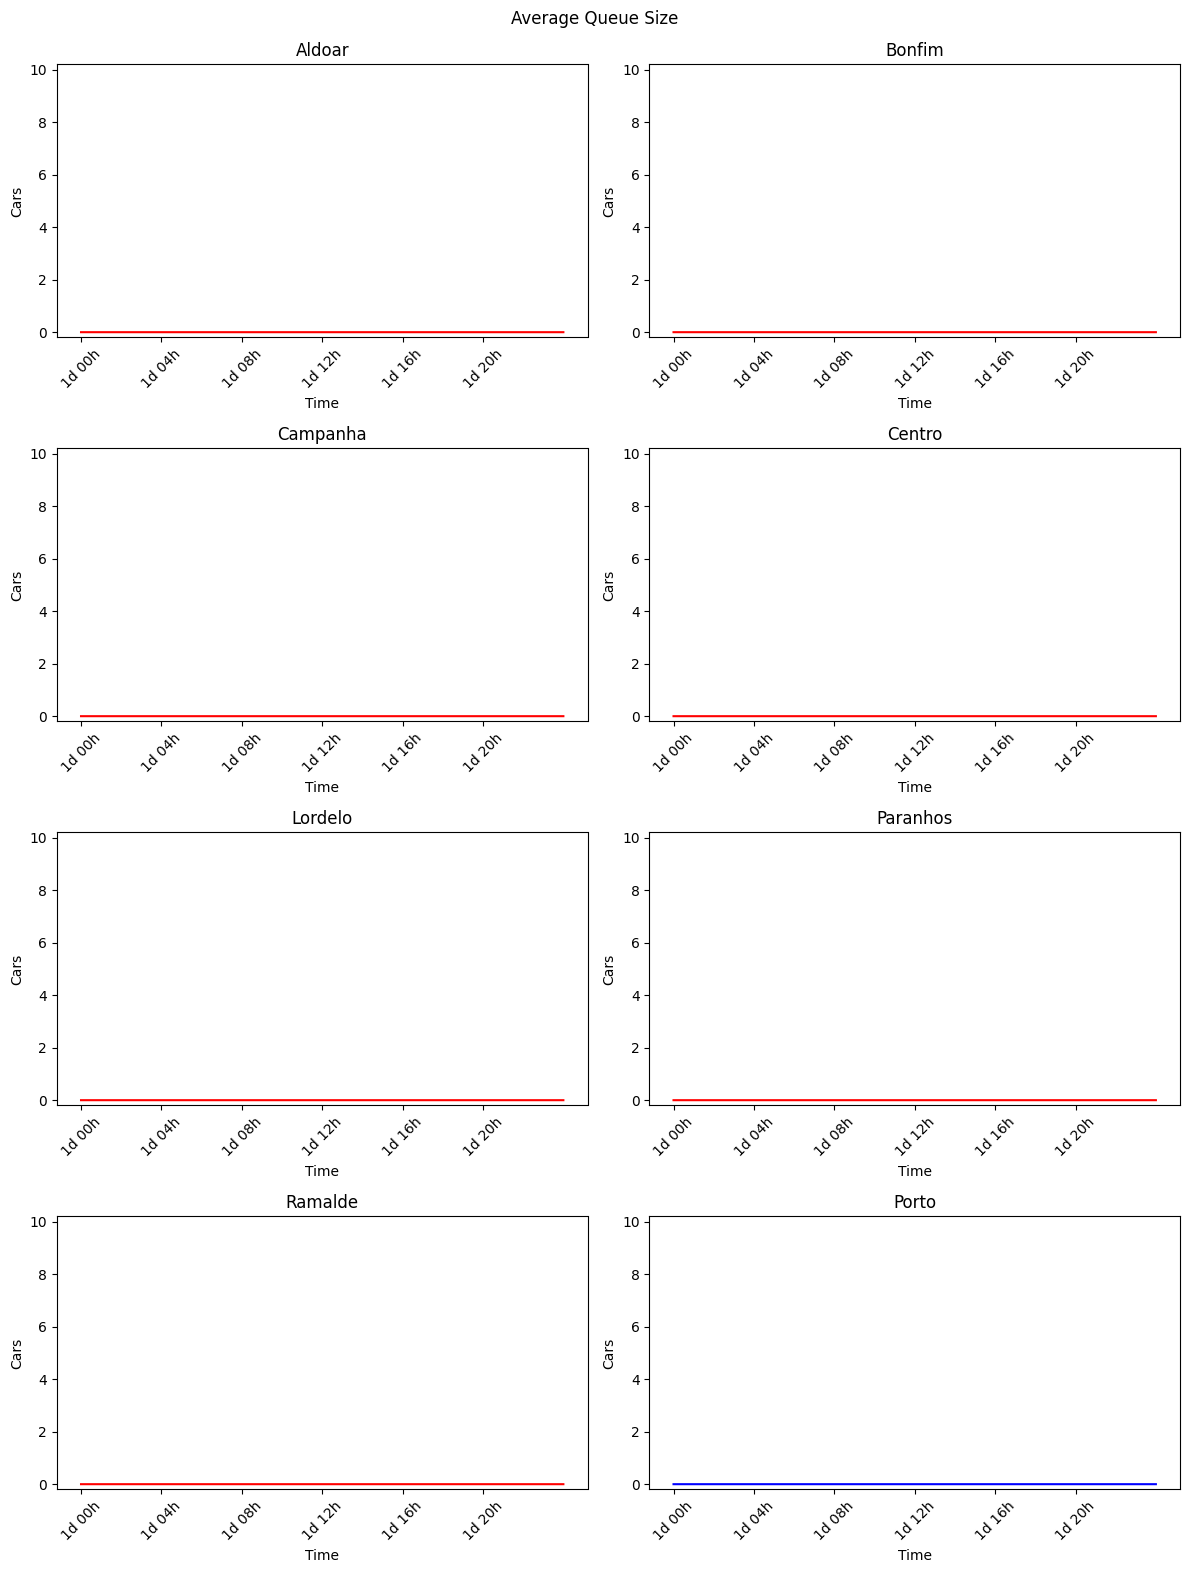

In [12]:
porto_data = np.zeros(steps)
for region in regions:
    porto_data += region_data[region]['queue']
porto_data = porto_data / len(regions)
limits = global_limits['queue'] if global_limits['queue'][1] > 0 else [0, 10]

plot_metric('queue', 'Average Queue Size', 'Cars', regions, region_data, porto_data, limits, 'r')

### Region Stress Level

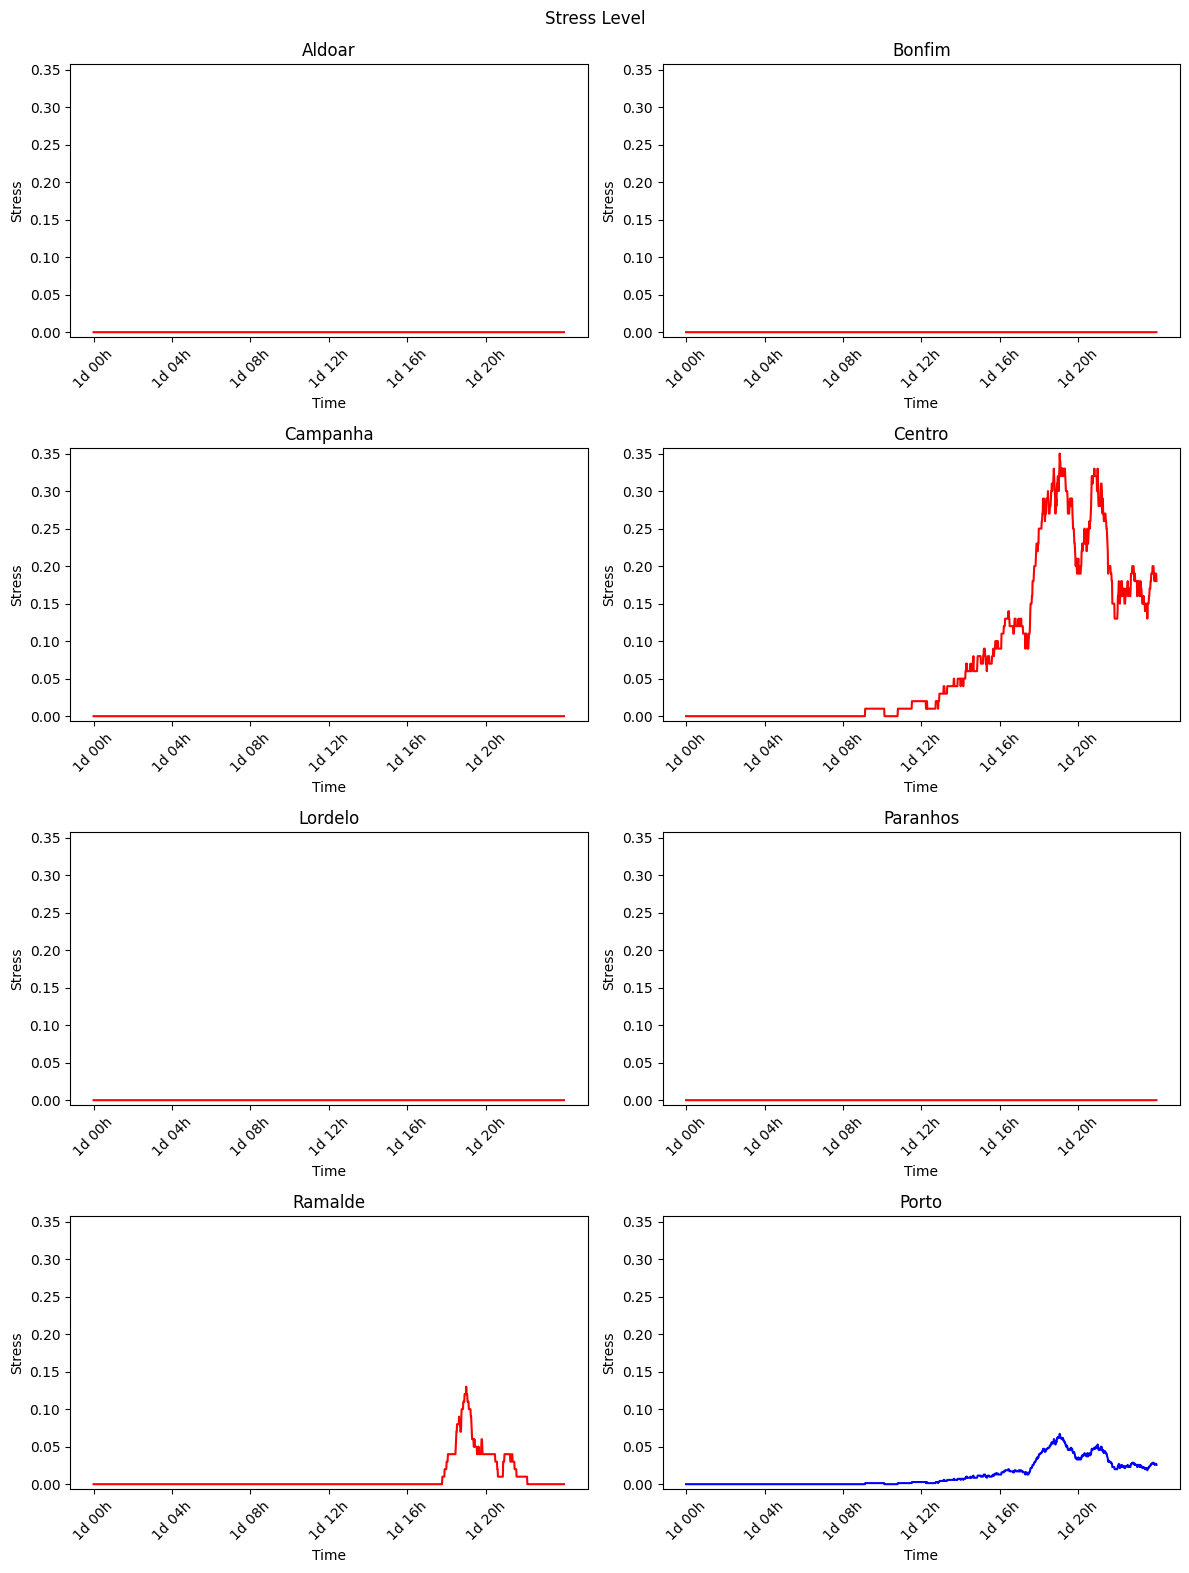

In [13]:
porto_data = np.zeros(steps)
for region in regions:
    porto_data += region_data[region]['stress']
porto_data /= len(regions)
limits = global_limits['stress'] if global_limits['stress'][1] > 0 else [0, 10]

plot_metric('stress', 'Stress Level', 'Stress', regions, region_data, porto_data, limits, 'r')

### Average Queue Wait Time

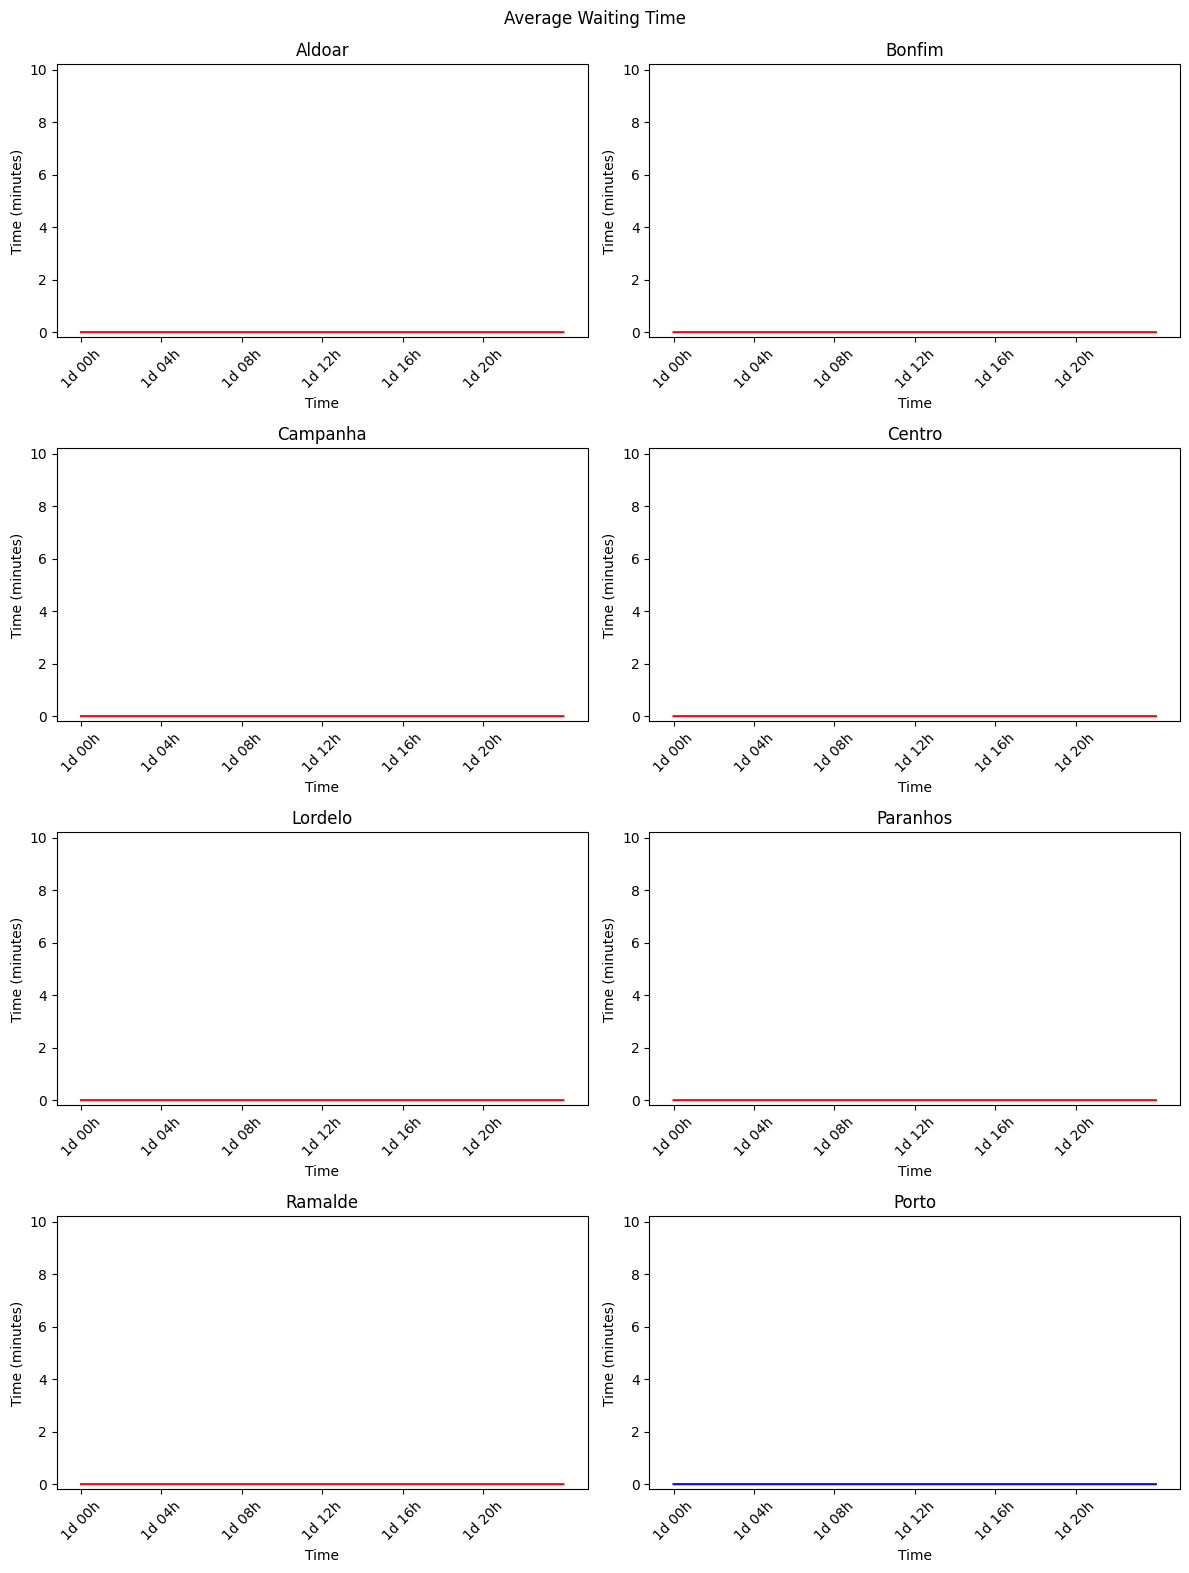

In [14]:
porto_data = np.zeros(steps)
for region in regions:
    porto_data += region_data[region]['wait']
porto_data /= len(regions)
limits = global_limits['wait'] if global_limits['wait'][1] > 0 else [0, 10]

plot_metric('wait', 'Average Waiting Time', 'Time (minutes)', regions, region_data, porto_data, limits, 'r')